# Analysing Player Rounds in Counter-Strike: Global Offensive

Counter-Strike: Global Offensive is a 2012 multiplayer tactical first-person shooter developed by Valve and Hidden Path Entertainment. It is the fourth game in the Counter-Strike series. With a massive fan base, tournament prizes exceeding 100 million dollars, and increasing viewership counts by the year boasting over a million viewers for their tournaments, Counter Strike has consistently maintained its position as one of the best e-sports games to come out, and is the best of all possible shooter games. It is no surprise that there arises cases where data from these games are required. Most common cases include predictive analysis, sports betting, and theory testing, among many others. In this notebook, we explore a dataset centering on the various properties in specific rounds during the game.


## The Dataset

The dataset consists of round snapshots from about 700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot has been recorded every 20 seconds until the round is decided. Following its initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411. Snapshots are i.i.d and should be treated as individual data points, not as part of a match.

Source: https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification

In [1]:
import pandas as pd

df = pd.read_csv('csgo_round_snapshots.csv')

df = df.dropna() # drop any NA

df['round_winner_ct'] = [1 if a == 'CT' else 0 for a in df['round_winner']]

df['round_winner_t'] = [1 if a == 'T' else 0 for a in df['round_winner']]

In [2]:
df

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner,round_winner_ct,round_winner_t
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,1,0
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,1,0
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,1,0
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,1,0
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T,0,1
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,0,1
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T,0,1
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T,0,1


### Map Bias

There has been a general bias in maps. This is the recorded map bias from high-level play so far.

![title](images/map_bias.png)

Based on the data that we currently have, the maps are roughly fair. Although each map's terrain may pose challenges and benefits for certain sides, in this notebook, we can assume that the map terrain is not a significant factor in determining the winner of the game

## Hypothesis: There is a linear relationship between winning the round and the difference in net worth of a team

To first test this out, we need to establish the net worth of the team. The net worth of a team is the total value in the form of items that a team has equipped.

In [3]:
## Creating Prices - Prices found relates to general prices back in 2019-20. Some prices may vary slightly due to some price changes that happened during the 2019-20 season.

pricesw = {'glock' : 200, 'p2000': 200, 'usps': 200, 'elite': 400, 'p250': 300, 'tec9': 500, 'fiveseven': 500, 'cz75auto': 500, 'deagle': 700, 'r8revolver': 600, 'nova': 1050, 'xm1014': 2000, 'sawedoff': 1100, 'mag7': 1700, 'negev': 1700, 'mac10': 1500, 'mp5sd': 1500, 'mp7': 1700, 'mp9': 1250, 'ump45': 1200, 'galilar': 1800, 'famas': 2050, 'm4a1s': 2900, 'm4a4': 3100, 'ssg08': 1700, 'sg553': 3000, 'ak47': 2700, 'aug': 3300, 'awp': 4750, 'bizon': 1400, 'g3sg1': 5000, 'scar20': 5000, 'm249': 5200}

pricesg = {'hegrenade': 300, 'flashbang': 200, 'smokegrenade': 300, 'molotovgrenade': 400, 'incendiarygrenade': 600, 'decoygrenade': 50}

pricesmisc = {'defuse_kits': 400, 'armor': 6.5, 'helmets': 3.5}

ct_net = []
t_net = []
for index, row in df.iterrows():
    sumt, sumc = 0, 0
    for id in ('t_', 'ct_'):
        for weaponname in pricesw:
            if id == 't_':
                sumt += (row[id+'weapon_'+weaponname] * pricesw[weaponname])
            else:
                sumc += (row[id+'weapon_'+weaponname] * pricesw[weaponname])
        for grenadename in pricesg:
            if id == 't_':
                sumt += (row[id+'grenade_'+grenadename] * pricesg[grenadename])
            else:
                sumc += (row[id+'grenade_'+grenadename] * pricesg[grenadename])
        for miscname in pricesmisc:
            if miscname == 'defuse_kits':
                sumc += (row['ct_defuse_kits'] * pricesmisc[miscname])
            elif id == 't_':
                sumt += (row[id+miscname] * pricesmisc[miscname])
            else:
                sumc += (row[id+miscname] * pricesmisc[miscname])
    ct_net.append(sumc)
    t_net.append(sumt)
        

In [4]:
# Add ct_net as a new column
df['ct_net'] = ct_net

# Add t_net as another new column
df['t_net'] = t_net

# Add net difference (positive means CT has more value than T)
df['net_diff'] = df['ct_net'] - df['t_net']

#### Optional: Convert DataFrame to Attribute-Relation File Format (ARFF)

ARFF is a file format that is used by WEKA. We can use WEKA for easier analysis on different aspects of the data and draw out more detailed conclusions.

In [5]:
import arff

def dataframe_to_arff(df, filename, relation="relation", description=""):
    attribute_list = []

    # Create attribute list
    for column_name, column_data in df.items():
        if pd.api.types.is_numeric_dtype(column_data):
            attribute_list.append((column_name, 'NUMERIC'))
        elif pd.api.types.is_string_dtype(column_data):
            attribute_list.append((column_name, 'STRING'))
        elif pd.api.types.is_categorical_dtype(column_data):
            attribute_list.append((column_name, column_data.cat.categories.tolist()))
        else:
            # Add more types if necessary
            attribute_list.append((column_name, 'STRING'))

    # Create the dictionary
    arff_dict = {
        'attributes': attribute_list,
        'data': df.values.tolist(),
        'relation': relation,
        'description': description
    }

    # Dump to ARFF file format
    with open(filename, 'w') as f:
        arff.dump(arff_dict, f)


In [6]:
# Convert to arff
dataframe_to_arff(df[['time_left', 't_net', 'ct_net', 'net_diff', 'round_winner']], 'economy.arff', relation='csgo')

#### Initial Observations

We visualise the data with two boxplots; one for each class. We observe that the boxplot for CT is higher than that of T, but a closer look shows that both of these boxplots have many outliers.

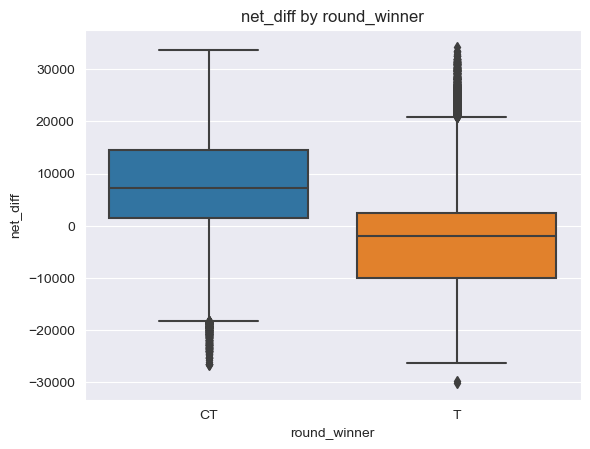

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
sns.boxplot(x='round_winner', y='net_diff', data=df)
plt.title("net_diff by round_winner")
plt.show()

This will prove to be a problem when we are testing for a correlation through logistic regression. We notice that while the model is able to achieve an accuracy of around 72%.

#### Testing The Hypothesis

We will use Linear Regression to test our hypothesis. Before we start, we will start to 'bin' the 'net_diff' attribute into different ordered categories. We want to observe how many T and CT wins for every category. We group net_diff in ranges of 100. 

In [8]:
# Create 'net_diff_ordered' by binning 'net_diff' into brackets of 100
df['net_diff_ordered'] = pd.cut(df['net_diff'], bins=range(-35000, 35001, 100), right=False)

# Create midpoints for original
midpoints = df['net_diff_ordered'].apply(lambda x: (x.left + x.right) / 2)
df['midp'] = pd.to_numeric(midpoints)

# Group by 'net_diff_ordered' and count the occurrences of 'T' and 'CT'
grouped = df.groupby('net_diff_ordered')['round_winner'].value_counts().unstack().fillna(0)

# Rename the columns for clarity
grouped.columns = ['howmany_ct', 'howmany_t']

# Reset index to make 'net_diff_ordered' a column
grouped.reset_index(inplace=True)

# Your new DataFrame
new_df = grouped

# Filter useless rows
new_df = new_df[(new_df['howmany_t'] != 0) | (new_df['howmany_ct'] != 0)]

# Add appropriate classes
midpoints = new_df['net_diff_ordered'].apply(lambda x: (x.left + x.right) / 2)
new_df['midp'] = pd.to_numeric(midpoints)
new_df['howmany_t_percent'] = (new_df['howmany_t'] * 100) / (new_df['howmany_ct'] + new_df['howmany_t']) 
new_df['howmany_ct_percent'] = (new_df['howmany_ct'] * 100) / (new_df['howmany_ct'] + new_df['howmany_t']) 
new_df['win_diff_raw'] = new_df['howmany_ct'] - new_df['howmany_t']
new_df['win_diff_percent'] = new_df['howmany_ct_percent'] - new_df['howmany_t_percent']



/var/folders/t6/8_j6sq2d6sg4r3mwm0l7ppx80000gn/T/ipykernel_5291/4047411499.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['midp'] = pd.to_numeric(midpoints)
/var/folders/t6/8_j6sq2d6sg4r3mwm0l7ppx80000gn/T/ipykernel_5291/4047411499.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['howmany_t_percent'] = (new_df['howmany_t'] * 100) / (new_df['howmany_ct'] + new_df['howmany_t'])
/var/folders/t6/8_j6sq2d6sg4r3mwm0l7ppx80000gn/T/ipykernel_5291/4047411499.py:27: SettingWithCopyWarning: 
A 

In [9]:
new_df.shape

(605, 8)

In [10]:
# Removing Outliers 
LQ = new_df['midp'].quantile(0.1)
HQ = new_df['midp'].quantile(0.9)

# Filter out outliers
new_df = new_df[(new_df['midp'] >= LQ) & (new_df['midp'] <= HQ)]

In [11]:
new_df

,net_diff_ordered,howmany_ct,howmany_t,midp,howmany_t_percent,howmany_ct_percent,win_diff_raw,win_diff_percent
145,"[-20500, -20400)",6,80,-20450.0,93.023256,6.976744,-74,-86.046512
146,"[-20400, -20300)",5,98,-20350.0,95.145631,4.854369,-93,-90.291262
147,"[-20300, -20200)",4,87,-20250.0,95.604396,4.395604,-83,-91.208791
148,"[-20200, -20100)",7,88,-20150.0,92.631579,7.368421,-81,-85.263158
149,"[-20100, -20000)",8,71,-20050.0,89.873418,10.126582,-63,-79.746835
...,...,...,...,...,...,...,...,...
623,"[27300, 27400)",57,4,27350.0,6.557377,93.442623,53,86.885246
624,"[27400, 27500)",77,4,27450.0,4.938272,95.061728,73,90.123457
625,"[27500, 27600)",54,5,27550.0,8.474576,91.525424,49,83.050847
626,"[27600, 27700)",54,7,27650.0,11.475410,88.524590,47,77.049180


In [12]:
# Optional - Save as .csv
new_df[['midp', 'win_diff_percent']].to_csv('checkdata.csv', index=False)

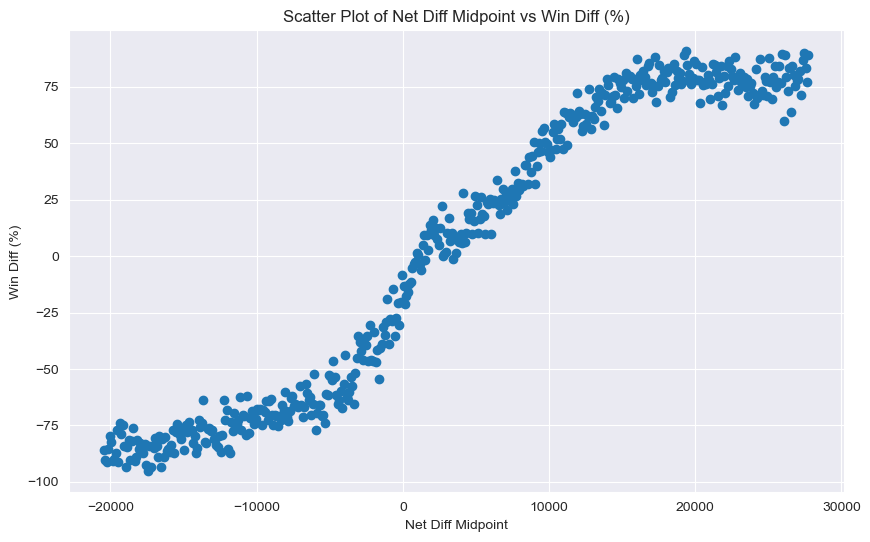

In [13]:
# Plot The Curves
plt.figure(figsize=(10, 6))
plt.scatter(new_df['midp'], new_df['win_diff_percent'])

plt.xlabel('Net Diff Midpoint')
plt.ylabel('Win Diff (%)')
plt.title('Scatter Plot of Net Diff Midpoint vs Win Diff (%)')
plt.savefig('filtered.png')
plt.show()

We observe that graphically, there seems to be a correlation, but the data becomes more erratic for the extreme values. This might be due to the fact that 'net_diff' has a heavy-tailed distribution (a two-tailed bell-shaped figure can be seen if you plot the curve), which results in high probability of outliers. We can use a Q-Q plot to check for this.

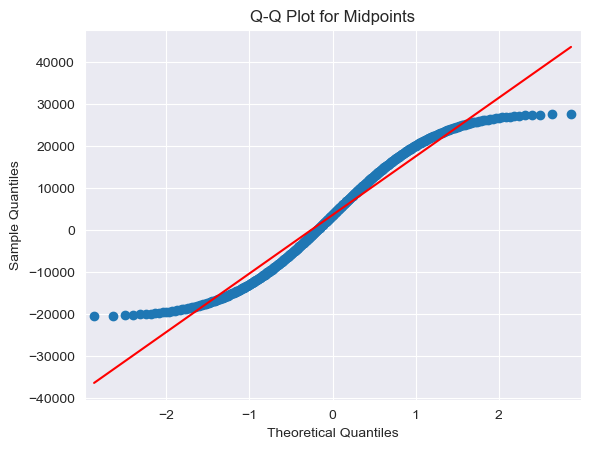

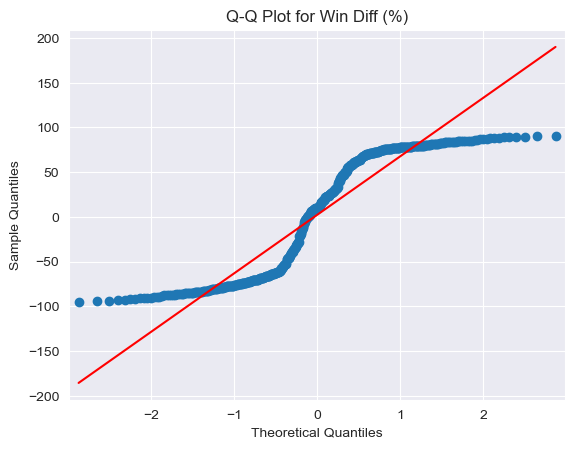

In [14]:
# Q-Q plot for 'midpoints'
import numpy as np
import statsmodels.api as sm

sm.qqplot(new_df['midp'], line ='s')
plt.title('Q-Q Plot for Midpoints')
plt.savefig('qqmid')
plt.show()

# Q-Q plot for 'win_diff_percent'
sm.qqplot(new_df['win_diff_percent'], line ='s')
plt.title('Q-Q Plot for Win Diff (%)')
plt.savefig('qqwindiff')
plt.show()

For both of the variables, it shows an S shaped plot. This indicates under-dispersed data, which corresponds to both ends being thin-tailed, but for most of the data, the graph shows that it generally still follows the line. Therefore it doesn't really affect the test as much. Hence we may proceed with the test. 

In [15]:
import scipy.stats as stats

stats.shapiro(new_df['win_diff_percent'])

ShapiroResult(statistic=0.8600755929946899, pvalue=2.37616678243807e-20)

#### Testing all forms of regression models

In [16]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model_linear = LinearRegression()

# Fit the model
model_linear.fit(new_df[['midp']], new_df['win_diff_percent'])

# Parameters of the model
print("MODEL PARAMETERS")
print("y-intercept (b):", model_linear.intercept_)
print("Parameters of 'Diameter' [a] are:", model_linear.coef_)
print("*"*20)

# Calculate the R-squared value
r_squared_linear = model_linear.score(new_df[['midp']], new_df['win_diff_percent'])
print("\nCORRELATION COEFFICIENT OF MODEL")
print("Correlation coefficient (R-squared):", r_squared_linear)

MODEL PARAMETERS
y-intercept (b): -14.326813888181938
Parameters of 'Diameter' [a] are: [0.0045427]
********************

CORRELATION COEFFICIENT OF MODEL
Correlation coefficient (R-squared): 0.9355656312982558


In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Train polynomial regression model on the whole dataset
pr = PolynomialFeatures(degree = 2)
midp_quad = pr.fit_transform(new_df[['midp']])
model_quad = LinearRegression()
model_quad.fit(midp_quad, new_df['win_diff_percent'])

# Parameters of the model
print("MODEL PARAMETERS")
print("y-intercept (c):", model_quad.intercept_)
print("Parameters of 'Diameter' [b, a] are:", model_quad.coef_[1: ]) # The 0th element in polynomial fits does not count since bias is found in model2.intercept_
print("*"*20)

# Calculate the R-squared value
r_squared_quad = model_quad.score(midp_quad, new_df['win_diff_percent'])
print("\nCORRELATION COEFFICIENT OF MODEL")
print("Correlation coefficient (R-squared):", r_squared_quad)

MODEL PARAMETERS
y-intercept (c): -10.81431371753947
Parameters of 'Diameter' [b, a] are: [ 4.68429791e-03 -1.93970585e-08]
********************

CORRELATION COEFFICIENT OF MODEL
Correlation coefficient (R-squared): 0.9382184866464036


In [18]:
# Train polynomial regression model on the whole dataset
pr2 = PolynomialFeatures(degree = 3)
midp_cube = pr2.fit_transform(new_df[['midp']])
model_cube = LinearRegression()
model_cube.fit(midp_cube, new_df['win_diff_percent'])


# Parameters of the model
print("MODEL PARAMETERS")
print("y-intercept is:", model_cube.intercept_)
print("Parameters of 'Diameter' [c, b, a] is:", model_cube.coef_[1: ])
print("*"*20)

# Calculate the R-squared value
r_squared_cube = model_cube.score(midp_cube, new_df['win_diff_percent'])
print("\nCORRELATION COEFFICIENT OF MODEL")
print("Correlation coefficient (R-squared):", r_squared_cube)

MODEL PARAMETERS
y-intercept is: -18.975046476922415
Parameters of 'Diameter' [c, b, a] is: [ 6.74313322e-03  5.33351104e-08 -6.64220675e-12]
********************

CORRELATION COEFFICIENT OF MODEL
Correlation coefficient (R-squared): 0.9848692355335583


In [19]:
# Train polynomial regression model on the whole dataset
pr3 = PolynomialFeatures(degree = 4)
midp_four = pr3.fit_transform(new_df[['midp']])
model_four = LinearRegression()
model_four.fit(midp_four, new_df['win_diff_percent'])


# Parameters of the model
print("MODEL PARAMETERS")
print("y-intercept is:", model_four.intercept_)
print("Parameters [d, c, b, a] is:", model_four.coef_[1: ])
print("*"*20)

# Calculate the R-squared value
r_squared_four = model_four.score(midp_four, new_df['win_diff_percent'])
print("\nCORRELATION COEFFICIENT OF MODEL")
print("Correlation coefficient (R-squared):", r_squared_four)

MODEL PARAMETERS
y-intercept is: -18.45878805480687
Parameters [d, c, b, a] is: [ 6.81599140e-03  4.41248190e-08 -6.95675859e-12  2.16840434e-17]
********************

CORRELATION COEFFICIENT OF MODEL
Correlation coefficient (R-squared): 0.9849482425656514


In [32]:
### Creation of a ELU
from scipy.optimize import curve_fit

def gompertz(x, L ,x0, k, b):
    y = (L-b) * np.exp(-np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(new_df['win_diff_percent']) - min(new_df['win_diff_percent']), 
      np.median(new_df['midp']),
      0.05,
      np.mean(new_df['win_diff_percent'].values)] # this is an mandatory initial guess

param, param_cov = curve_fit(
    gompertz, new_df['midp'], 
    new_df['win_diff_percent'], 
    p0, 
    method='lm')

# Calculated the R-squared value
residuals = new_df['win_diff_percent']- gompertz(new_df['midp'], *param)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((new_df['midp']-np.mean(new_df['midp']))**2)
r_squared_gompertz= 1 - (ss_res / ss_tot)

# Calculate cutoff point
L, x0, k, b = param

# Calculate x for y = 0
if L != b and -b/(L - b) > 0:
    inner_log = np.log(-b / (L - b))
    if inner_log < 0:
        x_for_y_equals_zero = (1 / k) * (-np.log(-inner_log)) + x0
    else:
        x_for_y_equals_zero = None  # Undefined for non-negative inner log
else:
    x_for_y_equals_zero = None  # Undefined for L = b or non-positive fraction


# Parameters of the model
print("MODEL PARAMETERS")
print("Parameters are:", param)
print("Correlation coefficient (R-squared):", r_squared_gompertz)
print("Cutoff Point for Gompertz:", x_for_y_equals_zero)
print("*"*20)

MODEL PARAMETERS
Parameters are: [ 8.75816782e+01  1.27523040e+02  1.40382684e-04 -7.99954942e+01]
Correlation coefficient (R-squared): 0.9999997075146632
Cutoff Point for Gompertz: 2277.4791533383004
********************


/Users/rafaeltauran/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
from scipy.optimize import curve_fit

def tanh(x, L, x0, k, b):
    y = L * np.tanh(k * (x - x0)) + b
    return (y)

p0 = [max(new_df['win_diff_percent']) - min(new_df['win_diff_percent']),
      np.median(new_df['midp']),
      0.05,
      np.mean(new_df['win_diff_percent'].values)] # this is an mandatory initial guess

param3, param_cov3 = curve_fit(
    tanh, new_df['midp'],
    new_df['win_diff_percent'],
    p0,
    method='lm')

# Calculated the R-squared value
residuals3 = new_df['win_diff_percent']- tanh(new_df['midp'], *param3)
ss_res3 = np.sum(residuals3**2)
ss_tot3 = np.sum((new_df['midp']-np.mean(new_df['midp']))**2)
r_squared_tanh = 1 - (ss_res3 / ss_tot3)

# Parameters of the model
print("MODEL PARAMETERS")
print("Parameters are:", param3)
print("Correlation coefficient (R-squared):", r_squared_tanh)
print("*"*20)

MODEL PARAMETERS
Parameters are: [-5.96829856e+01  3.65826405e+03 -1.26279648e+02  2.37760610e+00]
Correlation coefficient (R-squared): 0.9999962652702936
********************


/Users/rafaeltauran/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [31]:
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(new_df['win_diff_percent']) - min(new_df['win_diff_percent']),
      np.median(new_df['midp']),
      0.01,
      np.mean(new_df['win_diff_percent'].values)] # this is an mandatory initial guess

param2, param_cov2 = curve_fit(
    sigmoid, new_df['midp'],
    new_df['win_diff_percent'],
    p0,
    method='lm')

# Calculated the R-squared value and cutoff point
L ,x0, k, b = param2
residuals2 = new_df['win_diff_percent']- sigmoid(new_df['midp'], *param2)
ss_res2 = np.sum(residuals2**2)
ss_tot2 = np.sum((new_df['midp']-np.mean(new_df['midp']))**2)
r_squared_sigmoid = 1 - (ss_res2 / ss_tot2)
cutoff_sigmoid = (1/k) * np.log(L/(-b) - 1) + x0

# Parameters of the model
print("MODEL PARAMETERS")
print("Parameters are:", param2)
print("Correlation coefficient (R-squared):", r_squared_sigmoid)
print("Cutoff Point for Sigmoid:", cutoff_sigmoid)
print("*"*20)

MODEL PARAMETERS
Parameters are: [ 1.69428759e+02  2.40618163e+03  2.00029107e-04 -8.67536701e+01]
Correlation coefficient (R-squared): 0.9999997287013781
Cutoff Point for Sigmoid: 2165.444713819186
********************


/Users/rafaeltauran/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


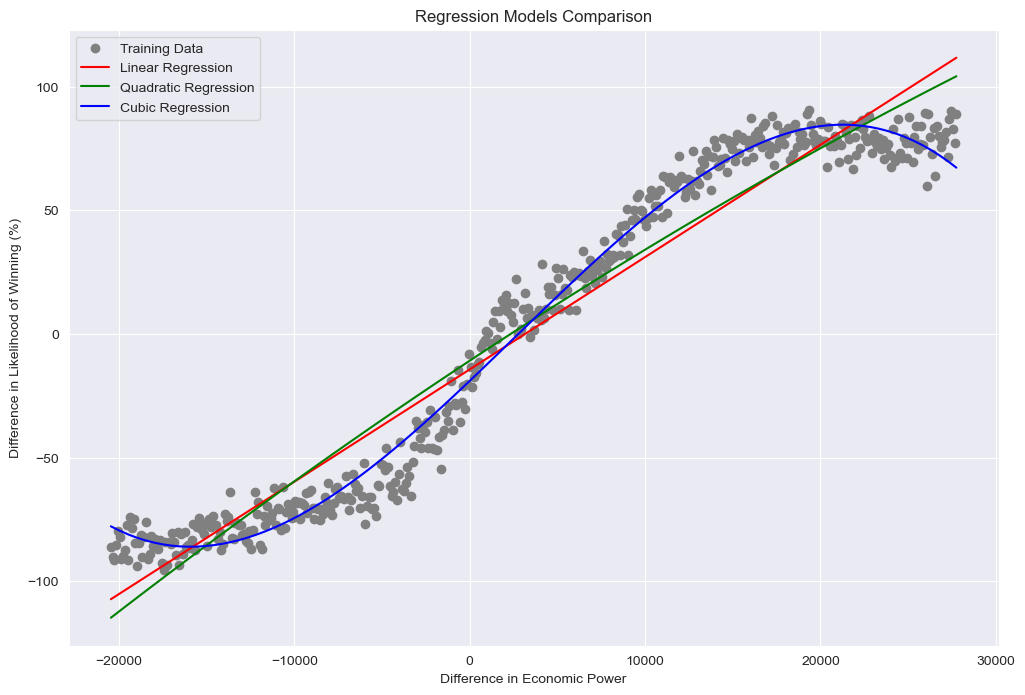

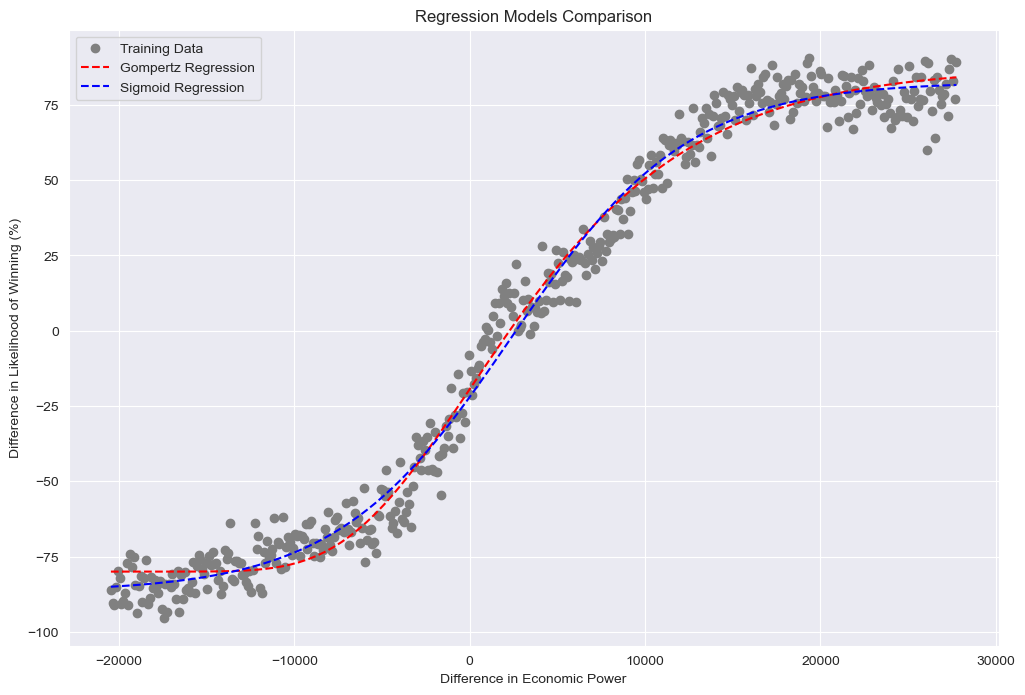

In [23]:
# Scatter plot of the original data
plt.figure(figsize=(12,8))
plt.scatter(new_df['midp'], new_df['win_diff_percent'], color='gray', label='Training Data')

# Create a range of values for plotting the regression lines
midp_range = np.linspace(new_df['midp'].min(), new_df['midp'].max(), 100).reshape(-1, 1)

# Linear model predictions
predictions_linear = model_linear.predict(midp_range)
plt.plot(midp_range, predictions_linear, label='Linear Regression', color='red')

# Quadratic model predictions
midp_quad = pr.fit_transform(midp_range)
predictions_quad = model_quad.predict(midp_quad)
plt.plot(midp_range, predictions_quad, label='Quadratic Regression', color='green')

# Cubic model predictions
midp_cube = pr2.fit_transform(midp_range)
predictions_cube = model_cube.predict(midp_cube)
plt.plot(midp_range, predictions_cube, label='Cubic Regression', color='blue')

plt.xlabel('Difference in Economic Power')
plt.ylabel('Difference in Likelihood of Winning (%)')
plt.title('Regression Models Comparison')
plt.legend()

# Show the first plot
plt.savefig('polyreg.png')
plt.show()

plt.figure(figsize=(12,8))
plt.scatter(new_df['midp'], new_df['win_diff_percent'], color='gray', label='Training Data')
# Gompertz model predictions
predictions_gompertz = gompertz(midp_range, *param)
plt.plot(midp_range, predictions_gompertz, '--', label='Gompertz Regression', color='red')

# Sigmoid model predictions
predictions_sigmoid = sigmoid(midp_range, *param2)
plt.plot(midp_range, predictions_sigmoid, '--', label='Sigmoid Regression', color='blue')

# Tanh model predictions
# predictions_tanh = tanh(midp_range, *param3)
# plt.plot(midp_range, predictions_tanh, '--', label='Tanh Regression', color='green')

# Labeling the plot
plt.xlabel('Difference in Economic Power')
plt.ylabel('Difference in Likelihood of Winning (%)')
plt.title('Regression Models Comparison')
plt.legend()

# Show the plot
plt.savefig('sigreg.png')
plt.show()


We can confidently test our classifier now with logistic regression.

              precision    recall  f1-score   support

          CT       0.74      0.69      0.71     19884
           T       0.72      0.76      0.74     20512

    accuracy                           0.73     40396
   macro avg       0.73      0.73      0.73     40396
weighted avg       0.73      0.73      0.73     40396

ROC AUC: 0.8121337927785367
Kappa Statistic: 0.4536042890691453
Class CT - FPR: 0.31100382216857775 TPR: 0.7641380655226209
Class T - FPR: 0.2358619344773791 TPR: 0.6889961778314222
Decision Boundary: 2757.032808916505


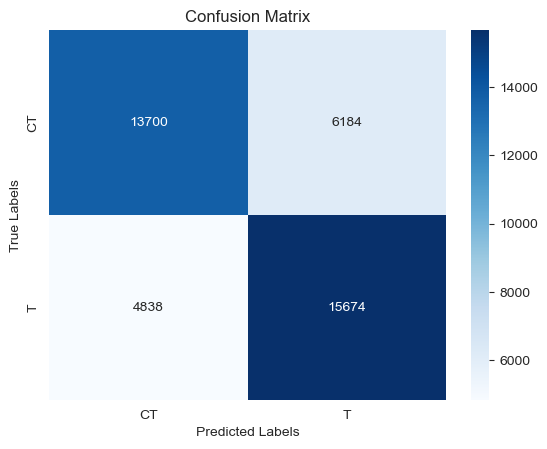

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split data into training and test sets to get some accuracy later on
X_train, X_test, y_train, y_test = train_test_split(df[['net_diff']], df['round_winner'], test_size=0.33, random_state=42)

# Logistic Regression Model
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# Get Basic Report
predictions_weight = logit_model.predict(X_test)
print(metrics.classification_report(y_test, predictions_weight))

# Get Kappa Score and ROC and AUC
from sklearn.metrics import roc_auc_score, cohen_kappa_score
# Get the probabilities of the positive class
y_prob = logit_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)


# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, predictions_weight)
print("Kappa Statistic:", kappa)

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Labels for the confusion matrix
labels = ['CT', 'T']

cm = confusion_matrix(y_test, predictions_weight, labels=labels)

# For Class 1
TP_1 = cm[1, 1]
FP_1 = cm[0, 1]
TN_1 = cm[0, 0]
FN_1 = cm[1, 0]

FPR_1 = FP_1 / (FP_1 + TN_1)
TPR_1 = TP_1 / (TP_1 + FN_1)

# For Class 0
TP_0 = cm[0, 0]
FP_0 = cm[1, 0]
TN_0 = cm[1, 1]
FN_0 = cm[0, 1]

FPR_0 = FP_0 / (FP_0 + TN_0)
TPR_0 = TP_0 / (TP_0 + FN_0)

print("Class CT - FPR:", FPR_1, "TPR:", TPR_1)
print("Class T - FPR:", FPR_0, "TPR:", TPR_0)

# Assuming logit_model is your trained Logistic Regression model
beta_0 = logit_model.intercept_[0]
beta_1 = logit_model.coef_[0][0]

# Calculate the decision boundary
decision_boundary = -beta_0 / beta_1

print("Decision Boundary:", decision_boundary)



# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('logconf.png')
plt.show()



/Users/rafaeltauran/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


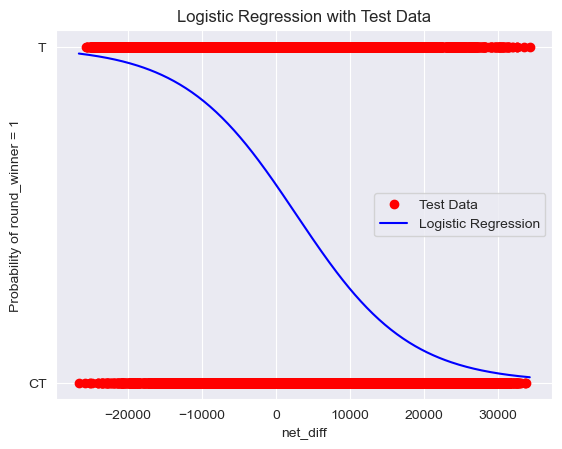

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot test data
plt.scatter(X_test, y_test, color='red', label='Test Data')

# Generate a range of values from minimum to maximum net_diff values
x_range = np.linspace(X_test.min(), X_test.max(), 300)

# Predict probabilities for these values
y_range_prob = logit_model.predict_proba(x_range.reshape(-1, 1))[:, 1]

# Plot logistic regression curve
plt.plot(x_range, y_range_prob, label='Logistic Regression', color='blue')

plt.xlabel('net_diff')
plt.ylabel('Probability of round_winner = 1')
plt.title('Logistic Regression with Test Data')
plt.legend()
plt.show()


Comparing the performance of Logistic Regression with a smooth step cubic function.

In [40]:
import numpy.polynomial.polynomial as poly

weights_lnr = [model_linear.intercept_]
weights_lnr.extend(model_linear.coef_)
roots_lnr = poly.polyroots(weights_lnr)

weights_quad = [model_quad.intercept_]
weights_quad.extend(model_quad.coef_[1: ])
roots_quad = poly.polyroots(weights_quad)

weights_cube = [model_cube.intercept_]
weights_cube.extend(model_cube.coef_[1: ])
roots_cube = poly.polyroots(weights_cube)

average_cutoff = (roots_lnr[0] + roots_quad[0] + roots_cube[1] + x_for_y_equals_zero + cutoff_sigmoid)/5

2540.4014479565594


We will use the value within the range (-20000, 20000) as our root. This visually corresponds to the middle point of our curve.

In [41]:
def predict_batch(X):
    return ['CT' if x > average_cutoff else 'T' for x in X]

              precision    recall  f1-score   support

          CT       0.74      0.70      0.72     19884
           T       0.72      0.76      0.74     20512

    accuracy                           0.73     40396
   macro avg       0.73      0.73      0.73     40396
weighted avg       0.73      0.73      0.73     40396

ROC AUC: 0.7282416447532977
Kappa Statistic: 0.45682936192977874
Class CT - FPR: 0.30034198350432506 TPR: 0.7568252730109204
Class T - FPR: 0.24317472698907958 TPR: 0.6996580164956749
Decision Boundary: 2540.4014479565594


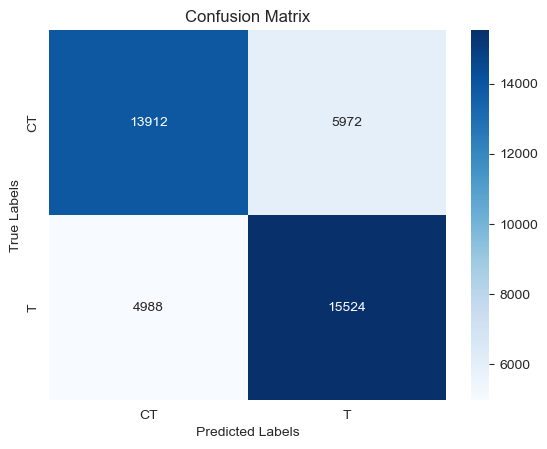

In [46]:
# Test on stuff
y_pred = predict_batch(X_test.values)
print(metrics.classification_report(y_test, y_pred))

# Get Kappa Score and ROC and AUC
from sklearn.metrics import roc_auc_score, cohen_kappa_score

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, [0 if p == 'CT' else 1 for p in y_pred])
print("ROC AUC:", roc_auc)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Statistic:", kappa)

# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Labels for the confusion matrix
labels = ['CT', 'T']

cm = confusion_matrix(y_test, y_pred, labels=labels)

# For Class 1
TP_1 = cm[1, 1]
FP_1 = cm[0, 1]
TN_1 = cm[0, 0]
FN_1 = cm[1, 0]

FPR_1 = FP_1 / (FP_1 + TN_1)
TPR_1 = TP_1 / (TP_1 + FN_1)

# For Class 0
TP_0 = cm[0, 0]
FP_0 = cm[1, 0]
TN_0 = cm[1, 1]
FN_0 = cm[0, 1]

FPR_0 = FP_0 / (FP_0 + TN_0)
TPR_0 = TP_0 / (TP_0 + FN_0)

print("Class CT - FPR:", FPR_1, "TPR:", TPR_1)
print("Class T - FPR:", FPR_0, "TPR:", TPR_0)
print("Decision Boundary:", average_cutoff)


# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('customconf.png')
plt.show()

## Corollary: Teams are unlikely to win if they are in an eco round [Unfinished]

In [29]:
# Creating an array of indexes the weapons and armour (helmet included)
ct_idx_arr = [num for num in range(5, 84) if (num % 2 == 0 and num >= 16) or num == 7 or num == 11]
t_idx_arr =[num for num in range(5, 84) if (num % 2 != 0 and num >= 16) or num == 8 or num == 12]

# Filter
t_side_df = df.iloc[:, t_idx_arr]
ct_side_df = df.iloc[:, ct_idx_arr]

# Pistols
t_pistols = ['t_weapon_cz75auto', 't_weapon_elite', 't_weapon_glock', 't_weapon_r8revolver', 't_weapon_deagle', 't_weapon_fiveseven', 't_weapon_usps', 't_weapon_p250', 't_weapon_p2000', 't_weapon_tec9']
ct_pistols = ['ct_weapon_cz75auto', 'ct_weapon_elite', 'ct_weapon_glock', 'ct_weapon_r8revolver', 'ct_weapon_deagle', 'ct_weapon_fiveseven', 'ct_weapon_usps', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_tec9']

# Remove
t_side_df = t_side_df.drop(columns=t_pistols)
ct_side_df = ct_side_df.drop(columns=ct_pistols)

# Armor and normal weapons are not bought
condition_t = (t_side_df == 0).all(axis=1)
condition_ct =(ct_side_df == 0).all(axis=1)

# Pistol Rounds
prt = df[t_pistols].sum(axis=1)
prc = df[ct_pistols].sum(axis=1)
pistol_round = (prc >= 5) & (prt >= 5)

# Removing pistol rounds
final_condition_t = condition_t & ~pistol_round
final_condition_ct = condition_ct & ~pistol_round

# Filtered dataframe
df_eco_t = df[final_condition_t]
df_eco_ct = df[final_condition_ct]

In [30]:
df_eco_t['midp']

39         6050.0
55        22150.0
153       10850.0
163        4750.0
194        1250.0
           ...   
122229     -150.0
122230      250.0
122238    13750.0
122239    13450.0
122390    10850.0
Name: midp, Length: 3000, dtype: float64